<a href="https://colab.research.google.com/github/atlasborn/LSTM-For-Trading/blob/main/LSTM_For_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installs
!pip install ccxt>=4.3.0 pandas>=2.2.0 numpy>=1.26.0 python-dotenv>=1.0.0 tensorflow>=2.17.0 scikit-learn>=1.5.0 matplotlib>=3.8.0 seaborn>=0.13.0 joblib>=1.4.0 openpyxl>=3.1.0

In [2]:
# Imports
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.random import set_seed
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import os
from dotenv import load_dotenv
import time
from datetime import datetime, timedelta

In [3]:
class Mexc:
  def __init__(self):
    #Carregar secrets
    load_dotenv()
    self.apikey = os.getenv('MEXC_API_KEY')
    self.apisecret = os.getenv('MEXC_API_SECRET')

    #Instanciar exchange
    self.exchange = ccxt.mexc({
      'apiKey': self.apikey,
      'secret': self.apisecret,
      'enableRateLimit': True,
    })

    # Valores padroes
    self.symbol = 'PENDLE/USDT'
    self.timeframe = '1h'
    self.days = 365*3
    self.csv_filename = f'{self.symbol.replace("/","_").lower()}_{self.timeframe}_historical_data.csv'

    #incializar variavel
    self.data = None


  # Função para obter dados da MEXC
  def fetch_mexc_data(self,symbol:str=None, days:int= None, timeframe:str = None) -> None: #
      end_date = datetime.now()
      if not days:
        days = self.days

      if not timeframe:
        timeframe = self.timeframe

      if not symbol:
        symbol = self.symbol

      self.days = days
      self.timeframe = timeframe
      self.symbol = symbol
      self.csv_filename = f'{symbol.replace("/","_").lower()}_{timeframe}_historical_data.csv'

      start_date = end_date - timedelta(days=days)
      since_timestamp = int(start_date.timestamp() * 1000)
      end_timestamp = int(end_date.timestamp() * 1000)
      all_ohlcv = []
      limit_per_request = 500
      timeframe_duration_ms = self.exchange.parse_timeframe(timeframe) * 1000

      print(f"Iniciando a busca de dados históricos de {symbol} ({timeframe}) da MEXC...")
      print(f"Período: de {start_date.strftime('%Y-%m-%d %H:%M')} até {end_date.strftime('%Y-%m-%d %H:%M')}")

      current_since = since_timestamp
      while current_since < end_timestamp:
          try:
              print(f"  Fazendo requisição a partir de: {datetime.fromtimestamp(current_since / 1000).strftime('%Y-%m-%d %H:%M:%S')}")
              ohlcv_chunk = self.exchange.fetch_ohlcv(symbol, timeframe, current_since, limit_per_request)
              if not ohlcv_chunk:
                  if current_since < end_timestamp:
                      print(f"  Aviso: Requisição para {datetime.fromtimestamp(current_since / 1000).strftime('%Y-%m-%d %H:%M')} retornou vazio. Avançando...")
                      current_since += timeframe_duration_ms * limit_per_request
                  else:
                      print("Fim da busca: atingiu o end_timestamp.")
                      break
              else:
                  all_ohlcv.extend(ohlcv_chunk)
                  current_since = ohlcv_chunk[-1][0] + timeframe_duration_ms
                  last_candle_time = datetime.fromtimestamp(ohlcv_chunk[-1][0] / 1000)
                  print(f"  Velas baixadas até: {last_candle_time.strftime('%Y-%m-%d %H:%M')} (Total: {len(all_ohlcv)} velas)")
              time.sleep(self.exchange.rateLimit / 1000)
          except ccxt.NetworkError as e:
              print(f"Erro de rede: {e}. Tentando novamente em 10 segundos...")
              time.sleep(10)
          except ccxt.ExchangeError as e:
              print(f"Erro da Exchange: {e}. Parando a busca.")
              break
          except Exception as e:
              print(f"Erro inesperado: {e}. Parando a busca.")
              break

      df = pd.DataFrame(all_ohlcv, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume'])
      df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
      df.drop_duplicates(subset=['Open time'], inplace=True)
      df.sort_values('Open time', inplace=True)
      df.reset_index(drop=True, inplace=True)
      df.to_csv(self.csv_filename, index=False)
      print(f"Dados salvos em '{self.csv_filename}'")
      self.data = df #save into mexc.data

      return None

In [4]:
class DataManager:
  def __init__(self, df: pd.DataFrame):
    self.df: pd.DataFrame = df
    self.df_scaled = None

  def get_info(self):
    print("Primeiras linhas do DataFrame:")
    print(self.df.head())
    print("\nInformações gerais do DataFrame:")
    print(self.df.info())
    print("\nEstatísticas descritivas detalhadas:")
    print(self.df.describe(include='all'))
    print("\nValores ausentes por coluna:")
    print(self.df.isnull().sum())

  def show_price_over_time(self):
    plt.figure(figsize=(12,6))
    plt.plot(self.df["Open time"], self.df["Close"], label="Close", color="red")
    plt.title("Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

  def show_volume_distribution(self):
    plt.figure(figsize=(12,6))
    plt.plot(self.df['Open time'], self.df['Volume'], label="Volume", color="purple")
    plt.title("Volume Over Time")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.legend()
    plt.show()

  def show_distributions(self):
    numeric_cols = self.df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
      plt.figure(figsize=(12, 4))

      # Histograma
      plt.subplot(1, 2, 1)
      sns.histplot(self.df[col], kde=True, color='blue')
      plt.title(f'Distribuição de {col}')
      plt.xlabel(col)
      plt.ylabel('Frequência')

      # Boxplot
      plt.subplot(1, 2, 2)
      sns.boxplot(y=self.df[col], color='green')
      plt.title(f'Boxplot de {col}')

      plt.tight_layout()
      plt.show()

  def preprocess_data(self):
    df = self.df.copy()
    scaler = StandardScaler()
    self.df_scaled = pd.DataFrame(scaler.fit_transform(df.select_dtypes(include=[np.number])),
                                 columns=df.select_dtypes(include=[np.number]).columns,
                                 index=df.index)

  def check_correlation_data(self):
    numeric_cols = self.df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(14, 10))
    sns.heatmap(self.df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
    plt.title("Matriz de Correlação")
    plt.tight_layout()
    plt.show()

  def load_indicators(self):
    # Indicadores existentes
    self.df['MA5'] = self.df['Close'].rolling(window=5).mean()
    self.df['MA10'] = self.df['Close'].rolling(window=10).mean()
    self.df['MA20'] = self.df['Close'].rolling(window=20).mean()
    self.df['BB_Middle'] = self.df['Close'].rolling(window=20).mean()
    self.df['BB_Std'] = self.df['Close'].rolling(window=20).std()
    self.df['BB_Upper'] = self.df['BB_Middle'] + (self.df['BB_Std'] * 2)
    self.df['BB_Lower'] = self.df['BB_Middle'] - (self.df['BB_Std'] * 2)
    self.df['BB_Width'] = (self.df['BB_Upper'] - self.df['BB_Lower']) / self.df['BB_Middle']
    self.df['ATR'] = np.maximum(
        self.df['High'] - self.df['Low'],
        np.maximum(
            abs(self.df['High'] - self.df['Close'].shift(1)),
            abs(self.df['Low'] - self.df['Close'].shift(1))
        )
    ).rolling(window=14).mean()

    # Níveis de Fibonacci
    self.fib_levels = [0.0, 0.236, 0.382, 0.5, 0.618, 0.786, 1.0]

    # Fibnc_1: Fibonacci com base na máxima e mínima do dia atual
    for level in self.fib_levels:
        self.df[f'Fibnc_1_{level}'] = self.df['Low'] + (self.df['High'] - self.df['Low']) * level

    # Fibnc_2: Fibonacci com base na máxima e mínima do dia anterior
    for level in self.fib_levels:
        self.df[f'Fibnc_2_{level}'] = self.df['Low'].shift(1) + (self.df['High'].shift(1) - self.df['Low'].shift(1)) * level
    # Fibnc_3: Fibonacci com base na máxima e mínima do dia anterior ao dia anterior
    for level in self.fib_levels:
        self.df[f'Fibnc_3_{level}'] = self.df['Low'].shift(2) + (self.df['High'].shift(2) - self.df['Low'].shift(2)) * level


In [5]:
mexc = Mexc()
mexc.fetch_mexc_data()

Iniciando a busca de dados históricos de PENDLE/USDT (1h) da MEXC...
Período: de 2022-08-08 15:38 até 2025-08-07 15:38
  Fazendo requisição a partir de: 2022-08-08 15:38:54
  Velas baixadas até: 2022-08-29 11:00 (Total: 500 velas)
  Fazendo requisição a partir de: 2022-08-29 12:00:00
  Velas baixadas até: 2022-09-19 07:00 (Total: 1000 velas)
  Fazendo requisição a partir de: 2022-09-19 08:00:00
  Velas baixadas até: 2022-10-10 03:00 (Total: 1500 velas)
  Fazendo requisição a partir de: 2022-10-10 04:00:00
  Velas baixadas até: 2022-10-30 23:00 (Total: 2000 velas)
  Fazendo requisição a partir de: 2022-10-31 00:00:00
  Velas baixadas até: 2022-11-20 19:00 (Total: 2500 velas)
  Fazendo requisição a partir de: 2022-11-20 20:00:00
  Velas baixadas até: 2022-12-11 15:00 (Total: 3000 velas)
  Fazendo requisição a partir de: 2022-12-11 16:00:00
  Velas baixadas até: 2023-01-01 11:00 (Total: 3500 velas)
  Fazendo requisição a partir de: 2023-01-01 12:00:00
  Velas baixadas até: 2023-01-22 07:0

In [6]:
if not mexc.data.empty:
  data = DataManager(mexc.data)
else:
  print("No data available")

In [7]:
data.get_info()

Primeiras linhas do DataFrame:
            Open time     Open     High      Low    Close    Volume
0 2022-08-08 16:00:00  0.06235  0.06242  0.06169  0.06171  95301.62
1 2022-08-08 17:00:00  0.06171  0.06183  0.06158  0.06165  44006.32
2 2022-08-08 18:00:00  0.06165  0.06167  0.06128  0.06133  83542.76
3 2022-08-08 19:00:00  0.06133  0.06140  0.06108  0.06119  63430.00
4 2022-08-08 20:00:00  0.06119  0.06189  0.06119  0.06189  69419.63

Informações gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open time  26280 non-null  datetime64[ns]
 1   Open       26280 non-null  float64       
 2   High       26280 non-null  float64       
 3   Low        26280 non-null  float64       
 4   Close      26280 non-null  float64       
 5   Volume     26280 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memor

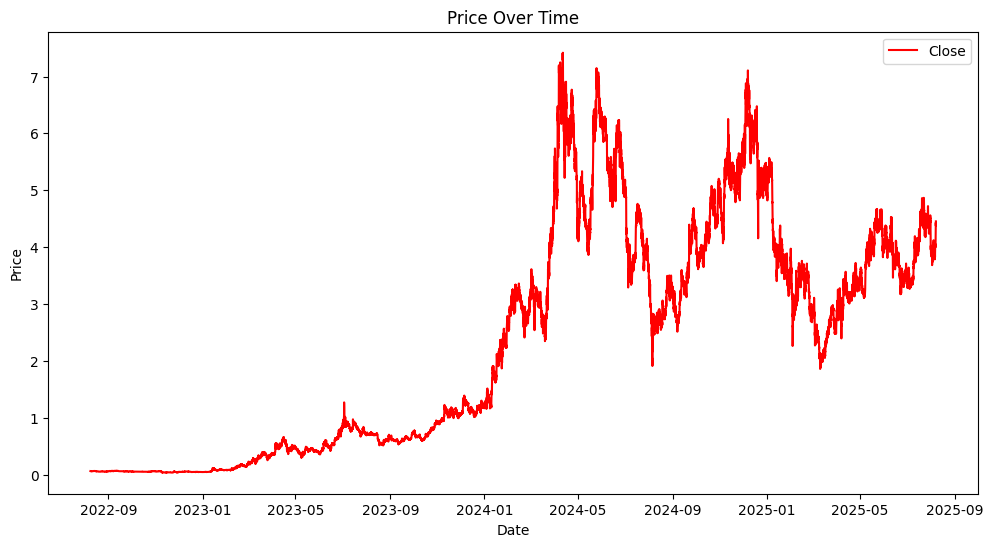

In [8]:
data.show_price_over_time()

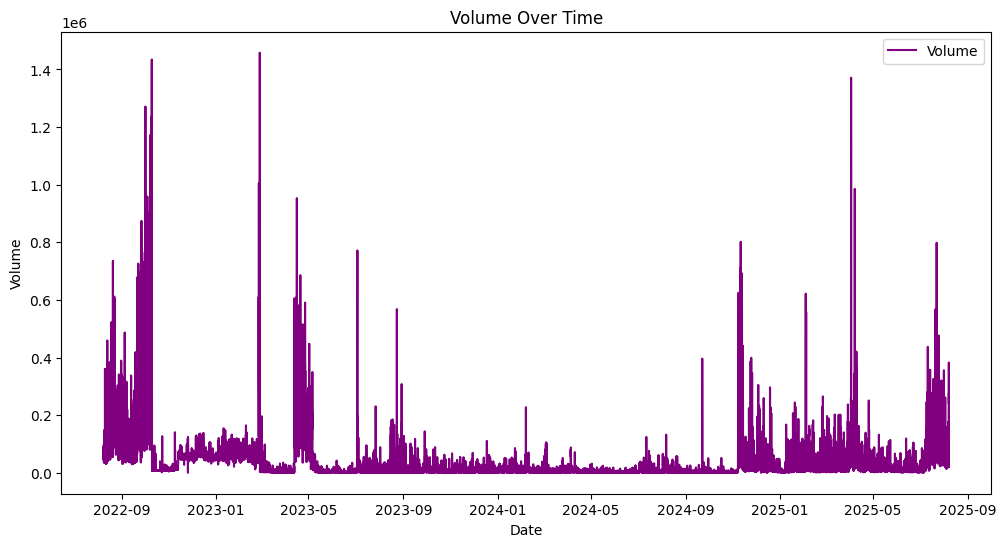

In [9]:
data.show_volume_distribution()

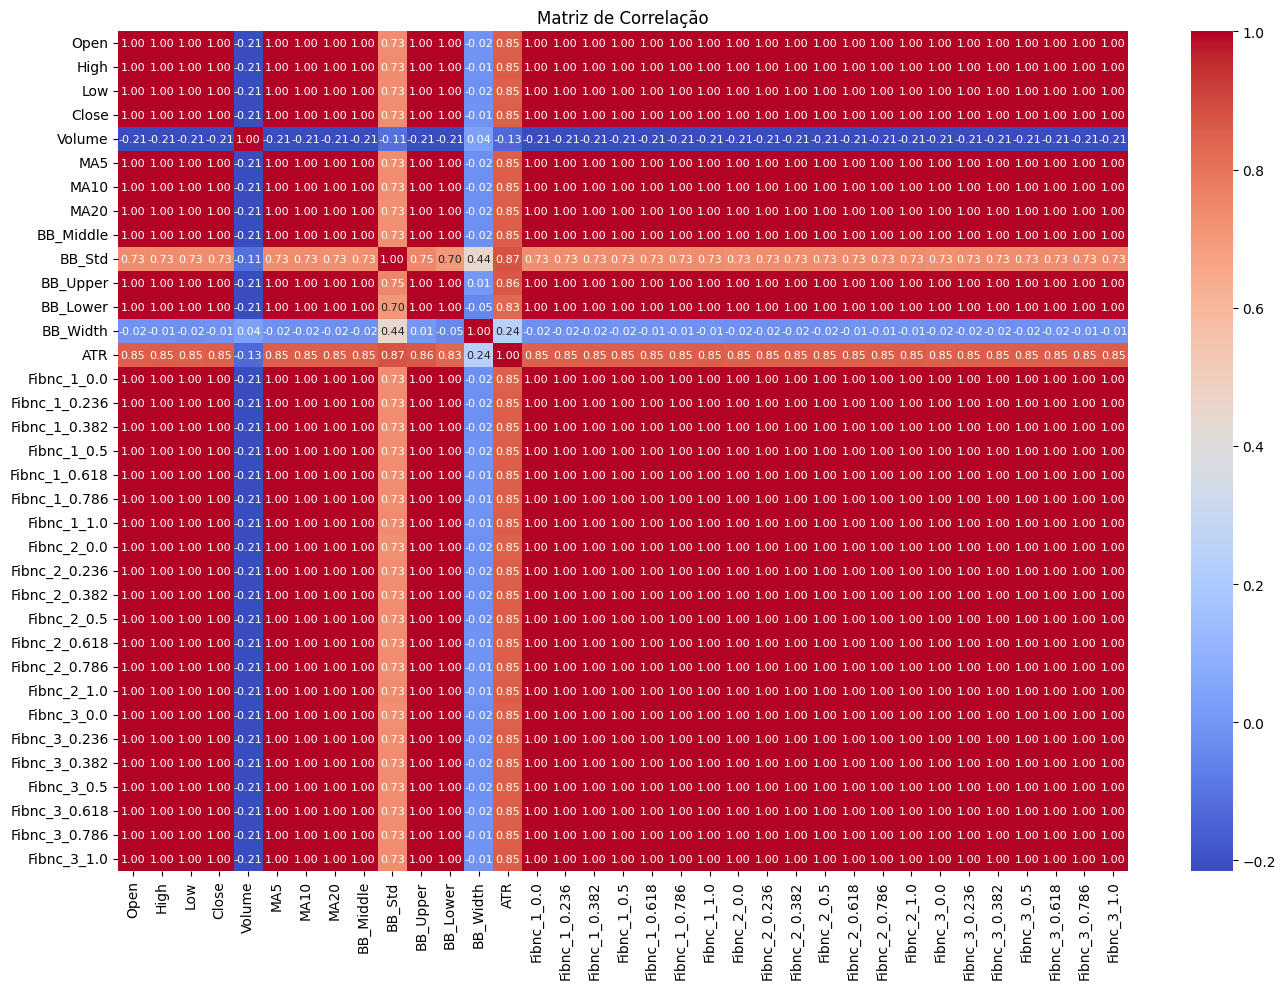

In [10]:
data.load_indicators()
data.check_correlation_data()

In [11]:
class AI:
  def __init__(self, df:pd.DataFrame = None, seed:int = 42):
    self.seed = seed
    os.environ["PYTHONHASHSEED"] = str(self.seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Força operações determinísticas no TensorFlow
    set_seed(self.seed)
    self.model = keras.models.Sequential()
    self.df:pd.DataFrame = data.df if df==None else df
    self.scaler = StandardScaler()
    self.window_size = 60
    self.train_test_split = 0.8
    self.training_data_len = None
    self.training = None
    self.x_train = None
    self.y_train = None
    self.x_test = None
    self.y_test = None
    self.training_data = None
    self.test_data = None
    self.input_shape = None




  def prepare_data(self) -> None:
    stock_close = self.df.filter(["Close"])
    dataset = stock_close.values
    self.training_data_len = int(np.ceil(len(dataset) * self.train_test_split))
    scaled_data = self.scaler.fit_transform(dataset)

    self.training_data = scaled_data[0:self.training_data_len, :]
    self.x_train, self.y_train = [], []

    # Create a sliding window for our stock (60)
    for i in range(60,len(self.training_data)):
      self.x_train.append(self.training_data[i-self.window_size:i,0])
      self.y_train.append(self.training_data[i,0])

    self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)
    self.input_shape = (self.x_train.shape[1], 1)
    self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1], 1))

    self.test_data = scaled_data[self.training_data_len - self.window_size:]
    self.x_test, self.y_test = [], dataset[self.training_data_len:]



    for i in range(self.window_size, len(self.test_data)):
      self.x_test.append(self.test_data[i-self.window_size:i,0])

    self.x_test = np.array(self.x_test)
    self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], self.x_test.shape[1], 1))


  def set_model(self, input_shape=None) -> None:
    self.model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=self.input_shape if input_shape == None else input_shape))
    self.model.add(keras.layers.LSTM(units=64, return_sequences=False))
    self.model.add(keras.layers.Dense(128, activation='relu'))
    self.model.add(keras.layers.Dropout(0.5))
    self.model.add(keras.layers.Dense(1, activation='relu'))
    self.model.summary()
    self.model.compile(optimizer='adam', loss='mae', metrics = [keras.metrics.RootMeanSquaredError()])

  def train_model(self, epochs:int=10, batch_size:int=32) -> None:
    self.training = self.model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch_size)


  def test_model(self) -> None:
    predictions = self.model.predict(self.x_test)
    predictions = self.scaler.inverse_transform(predictions)

    train = self.df[:self.training_data_len]
    valid = self.df[self.training_data_len:]
    valid = valid.copy()
    valid['Predictions'] = predictions

    plt.figure(figsize=(12,8))
    plt.plot(valid["Open time"], valid["Predictions"], label = "Predictions", color="purple")
    plt.plot(train["Open time"], train["Close"], label = "Train", color='green')
    plt.plot(valid["Open time"], valid["Close"], label = "Valid", color='yellow')
    plt.title("Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

  def predict(self, df):
    if len(dataset) < self.window_size:
      print("insuficient data")
      return None
    stock_close = self.df.filter(["Close"])
    dataset = stock_close.values
    scaled_data = self.scaler.fit_transform(dataset)
    x = scaled_data[-self.window_size:]
    x = np.array(x)
    x = np.reshape(x, (1, x.shape[0], 1))
    y = self.model.predict(dataset)
    y = self.scaler.inverse_transform(y)
    return y

In [12]:
ai = AI()


In [13]:
# Prepare os dados
ai.prepare_data()

In [14]:
# Crie o modelo
ai.set_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
ai.train_model()

Epoch 1/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - loss: 0.6425 - root_mean_squared_error: 0.7720
Epoch 2/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 0.6057 - root_mean_squared_error: 0.7474
Epoch 3/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 79s 62ms/step - loss: 0.6017 - root_mean_squared_error: 0.7464
Epoch 4/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.5978 - root_mean_squared_error: 0.7452
Epoch 5/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.5940 - root_mean_squared_error: 0.7443
Epoch 6/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - loss: 0.5928 - root_mean_squared_error: 0.7438
Epoch 7/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.5913 - root_mean_squared_error: 0.7436
Epoch 8/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - loss: 0.5906 - root_mean_squared_error: 0.7434
Epoch 9/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.5894 - root_mean_squared_error: 0.7429
Epoch 10/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.5882 - r

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


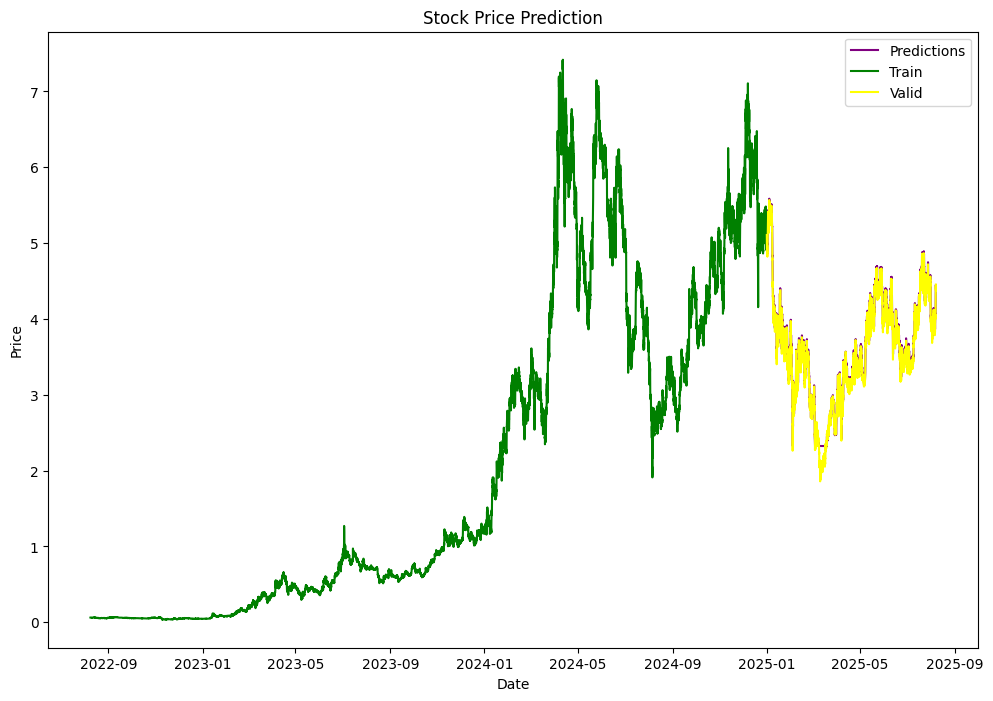

In [16]:
#test model
ai.test_model()

In [17]:
ai.predict(data)

UnboundLocalError: cannot access local variable 'dataset' where it is not associated with a value